In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
print("Row and Column of the dataset :",df.shape)

Row and Column of the dataset : (7043, 21)


In [38]:
print(df.isnull().values.any())

False


In [39]:
df.replace([' ', 'NaN', 'N/A'], np.nan, inplace=True)
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [40]:
duplicate_rows = df[df.duplicated()]
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")

Number of duplicate rows: 0


In [41]:
print("Before drop",df.shape)
df.dropna(inplace=True)
print("After drop",df.shape)
df.isnull().sum()


Before drop (7043, 21)
After drop (7032, 21)


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [ ]:
df.dtypes

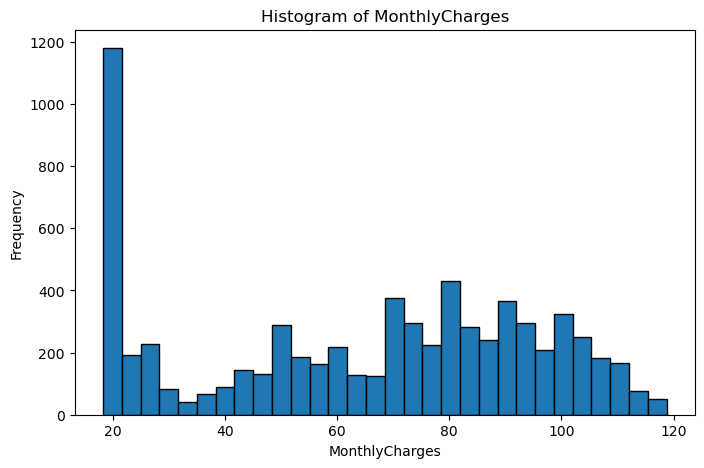

In [12]:
# 示例列: MonthlyCharges
column = 'MonthlyCharges'

# 绘制直方图
plt.figure(figsize=(8,5))
plt.hist(df[column], bins=30, edgecolor='k')
plt.title(f'Histogram of {column}')
plt.xlabel(column)
plt.ylabel('Frequency')
plt.show()

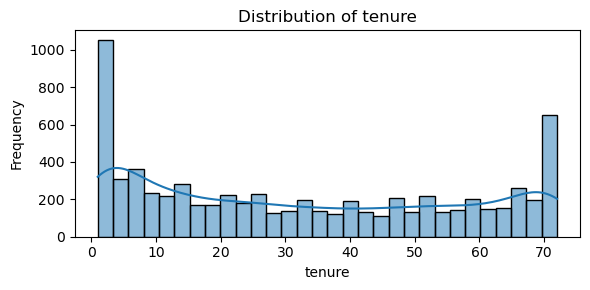

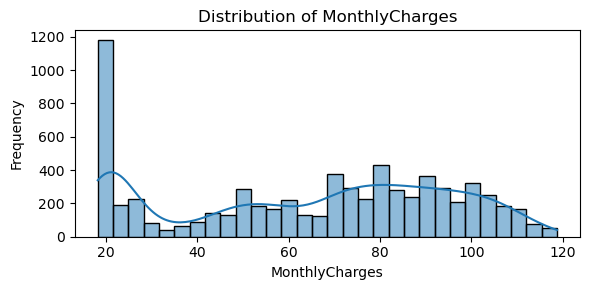

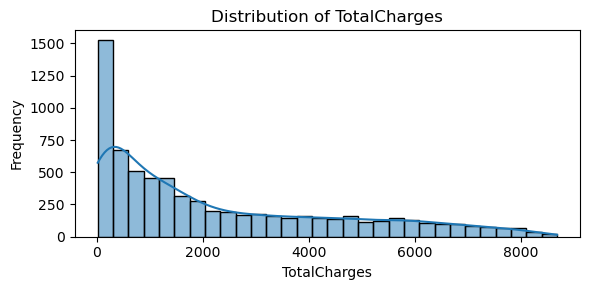

In [13]:
# 将 TotalCharges 转为 numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# 这里明确列出你要的三列
columns_to_plot = ['tenure', 'MonthlyCharges', 'TotalCharges']

# 绘制 histogram + kde
for col in columns_to_plot:
    plt.figure(figsize=(6, 3))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

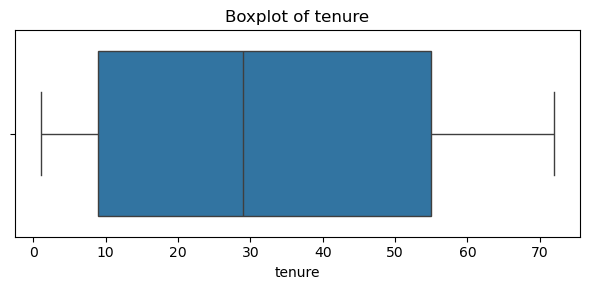

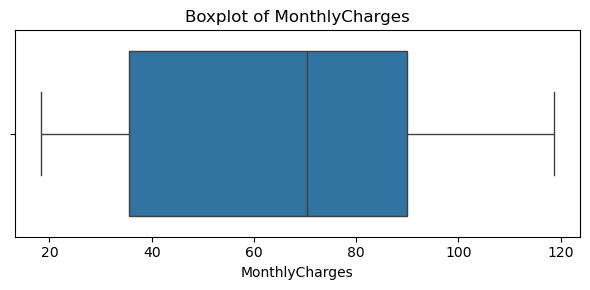

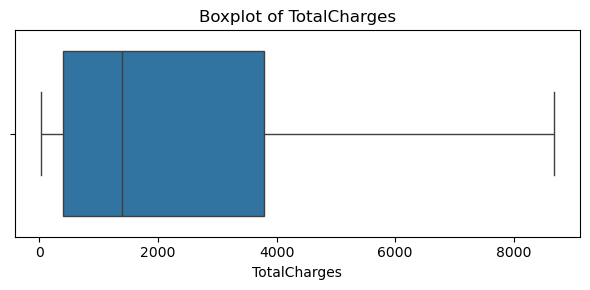

In [14]:
# 将 TotalCharges 转为 numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# 定义目标 columns
columns_to_plot = ['tenure', 'MonthlyCharges', 'TotalCharges']

# 绘制 boxplot
for col in columns_to_plot:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

In [42]:
print(df.apply(pd.Series.unique))


# 检查有 'No internet service' 和 'No phone service' 的 columns
replace_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                'StreamingTV', 'StreamingMovies', 'MultipleLines']

# 进行替换
for col in replace_cols:
    df[col] = df[col].replace({'No internet service': 'No', 'No phone service': 'No'})

# 验证替换结果
for col in replace_cols:
    print(f"Unique values in {col}: {df[col].unique()}")

df.apply(pd.Series.unique)

customerID          [7590-VHVEG, 5575-GNVDE, 3668-QPYBK, 7795-CFOC...
gender                                                 [Female, Male]
SeniorCitizen                                                  [0, 1]
Partner                                                     [Yes, No]
Dependents                                                  [No, Yes]
tenure              [1, 34, 2, 45, 8, 22, 10, 28, 62, 13, 16, 58, ...
PhoneService                                                [No, Yes]
MultipleLines                             [No phone service, No, Yes]
InternetService                                [DSL, Fiber optic, No]
OnlineSecurity                         [No, Yes, No internet service]
OnlineBackup                           [Yes, No, No internet service]
DeviceProtection                       [No, Yes, No internet service]
TechSupport                            [No, Yes, No internet service]
StreamingTV                            [No, Yes, No internet service]
StreamingMovies     

customerID          [7590-VHVEG, 5575-GNVDE, 3668-QPYBK, 7795-CFOC...
gender                                                 [Female, Male]
SeniorCitizen                                                  [0, 1]
Partner                                                     [Yes, No]
Dependents                                                  [No, Yes]
tenure              [1, 34, 2, 45, 8, 22, 10, 28, 62, 13, 16, 58, ...
PhoneService                                                [No, Yes]
MultipleLines                                               [No, Yes]
InternetService                                [DSL, Fiber optic, No]
OnlineSecurity                                              [No, Yes]
OnlineBackup                                                [Yes, No]
DeviceProtection                                            [No, Yes]
TechSupport                                                 [No, Yes]
StreamingTV                                                 [No, Yes]
StreamingMovies     

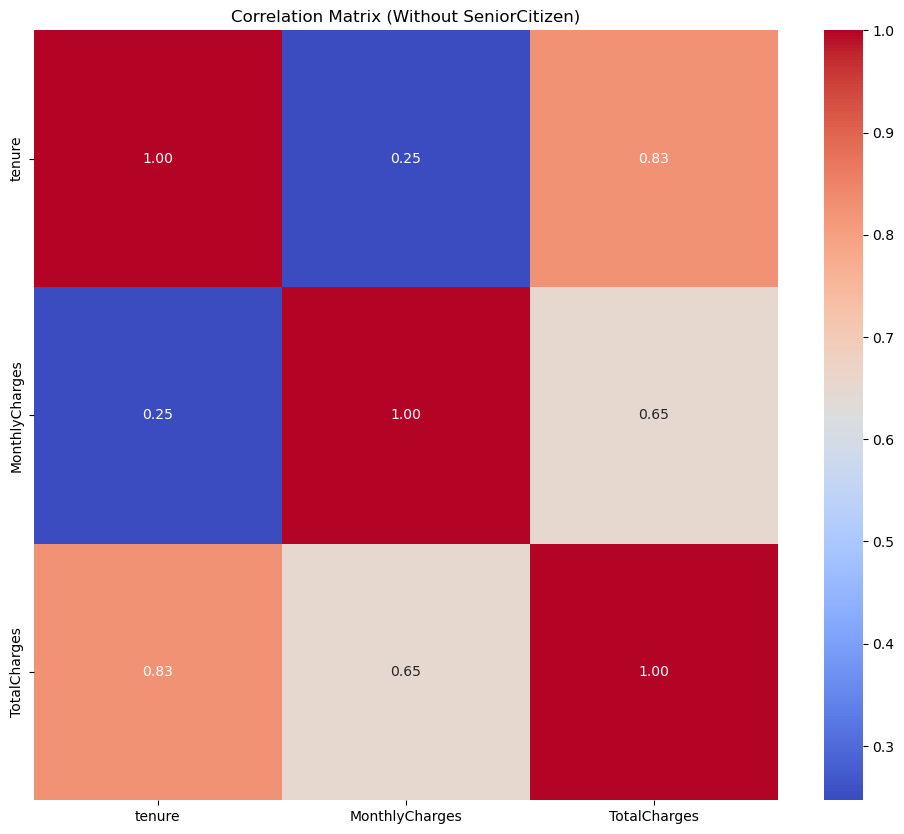

In [24]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# 选择 numeric columns
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# 计算 correlation matrix
corr = numeric_df.corr()

# 去除 SeniorCitizen row and column
corr = corr.drop(index='SeniorCitizen', columns='SeniorCitizen')

# 可视化
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix (Without SeniorCitizen)')
plt.show()

In [34]:
import pandas as pd
import scipy.stats as stats

# 选择分类列（排除 ID）
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('customerID')

print("Chi-Square Test Results:\n")
print("{:<25} {:>10} {:>12} {:>25}".format("Feature", "Chi2", "p-value", "Conclusion"))
print("-" * 75)

for col in categorical_cols:
    contingency_table = pd.crosstab(df[col], df['Churn'])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

    conclusion = "✅ Significant" if p < 0.05 else "❌ Not significant"
    print("{:<25} {:>10.2f} {:>12.4f} {:>25}".format(col, chi2, p, conclusion))


Chi-Square Test Results:

Feature                         Chi2      p-value                Conclusion
---------------------------------------------------------------------------
gender                          0.48       0.4905         ❌ Not significant
Partner                       157.50       0.0000             ✅ Significant
Dependents                    186.32       0.0000             ✅ Significant
PhoneService                    0.87       0.3499         ❌ Not significant
MultipleLines                  11.09       0.0009             ✅ Significant
InternetService               728.70       0.0000             ✅ Significant
OnlineSecurity                205.42       0.0000             ✅ Significant
OnlineBackup                   47.25       0.0000             ✅ Significant
DeviceProtection               30.50       0.0000             ✅ Significant
TechSupport                   189.97       0.0000             ✅ Significant
StreamingTV                    27.84       0.0000             

In [43]:
# 删除 gender 和 PhoneService 两个无显著关系的 feature
df = df.drop(['gender', 'PhoneService','customerID'], axis=1)

# 确认已删除
print(df.columns)



Index(['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
       'Churn'],
      dtype='object')


In [44]:
df.dtypes

SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
print("Row and Column of the dataset :",df.shape)

df.replace([' ', 'NaN', 'N/A'], np.nan, inplace=True)
print(df.isnull().sum())

df.dropna(inplace=True)
print("after remove :",df.shape)


df.dtypes

# 检查有 'No internet service' 和 'No phone service' 的 columns
replace_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                'StreamingTV', 'StreamingMovies', 'MultipleLines']

# 进行替换
for col in replace_cols:
    df[col] = df[col].replace({'No internet service': 'No', 'No phone service': 'No'})

# 验证替换结果
for col in replace_cols:
    print(f"Unique values in {col}: {df[col].unique()}")

df.apply(pd.Series.unique)

# 删除 gender 和 PhoneService 两个无显著关系的 feature
df = df.drop(['gender', 'PhoneService'], axis=1)
df = df.drop('customerID', axis=1)
# 确认已删除
print(df.columns)

# Convert SeniorCitizen from 0/1 to 'No'/'Yes'
df['SeniorCitizen'] = df['SeniorCitizen'].replace({1: 'Yes', 0: 'No'})

le = LabelEncoder()
# Encode target variable first
df['Churn'] = le.fit_transform(df['Churn'])

# Encode all other categorical features
cat_cols = df.select_dtypes(include='object').columns

for col in cat_cols:
    df[col] = le.fit_transform(df[col])

print(df.head())
print(df.dtypes)

Row and Column of the dataset : (7043, 21)
customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64
after remove : (7032, 21)
Unique values in OnlineSecurity: ['No' 'Yes']
Unique values in OnlineBackup: ['Yes' 'No']
Unique values in DeviceProtection: ['No' 'Yes']
Unique values in TechSupport: ['No' 'Yes']
Unique values in StreamingTV: ['No' 'Yes']
Unique values in StreamingMovies: ['No' 'Yes']
Unique values in MultipleLines: ['No' 'Yes']
Index(['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'MultipleLines',
       'InternetService', 'OnlineSecurity',

Churn
0    5163
1    1869
Name: count, dtype: int64
Churn
0    0.734215
1    0.265785
Name: proportion, dtype: float64


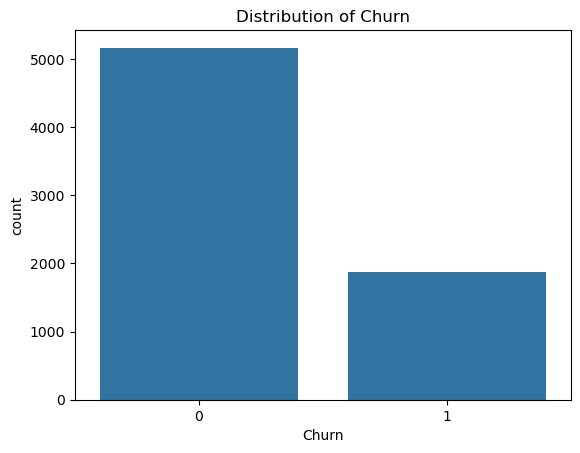

In [49]:
# 检查 Churn 的分布
print(df['Churn'].value_counts())

# 计算每个类别的比例
print(df['Churn'].value_counts(normalize=True))

# 也可以用bar plot 可视化
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Churn', data=df)
plt.title('Distribution of Churn')
plt.show()


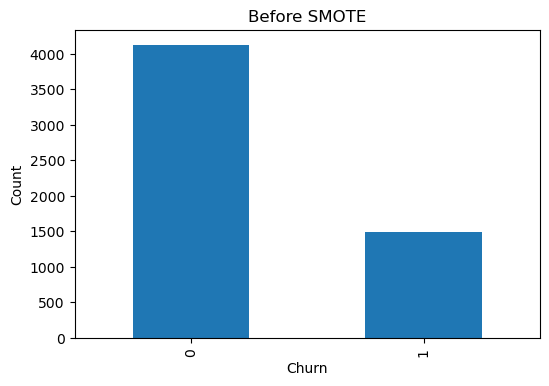

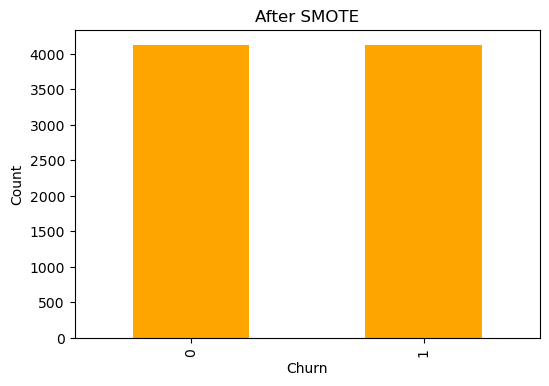

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# 将 features 和 target 分开
X = df.drop('Churn', axis=1)
y = df['Churn']

# 分割训练测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 使用 SMOTE 前的 bar chart（加 sort_index() 保持顺序）
plt.figure(figsize=(6,4))
y_train.value_counts().sort_index().plot(kind='bar')
plt.title("Before SMOTE")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.show()

# 初始化 SMOTE
smote = SMOTE(random_state=42)

# 对训练集 oversampling
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 使用 SMOTE 后的 bar chart（同样加 sort_index() 保持顺序）
plt.figure(figsize=(6,4))
y_train_smote.value_counts().sort_index().plot(kind='bar', color='orange')
plt.title("After SMOTE")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.show()




In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
# 初始化 Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_smote, y_train_smote)

# 预测测试集
y_pred = rf.predict(X_test)

# 评估模型
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Feature Importance
importances = rf.feature_importances_
features = X_train_smote.columns
indices = np.argsort(importances)[::-1]


Original shape: (7043, 21)
After dropping NA: (7032, 21)
Random Forest Model Performance:
Accuracy: 0.7647476901208244
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.82      0.84      1033
           1       0.55      0.61      0.58       374

    accuracy                           0.76      1407
   macro avg       0.70      0.72      0.71      1407
weighted avg       0.77      0.76      0.77      1407



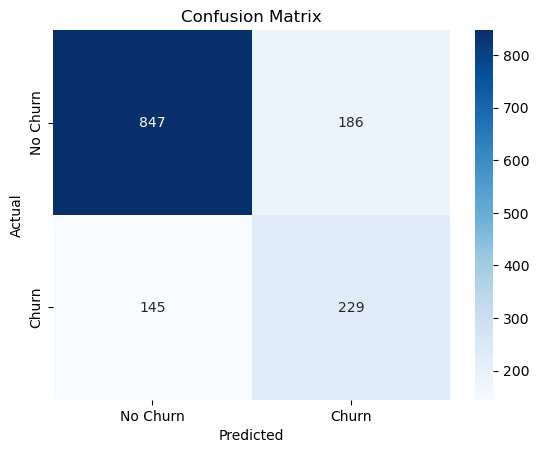

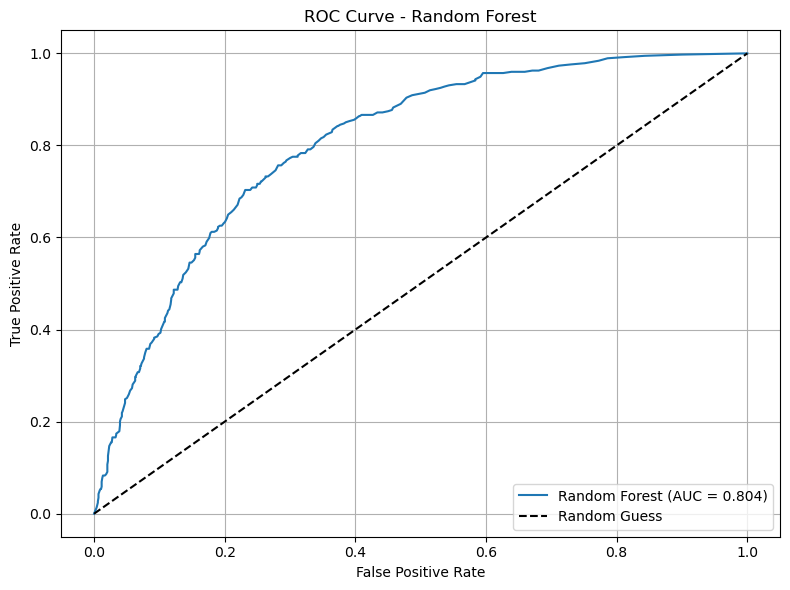

In [15]:
# Telco Customer Churn Prediction using SMOTE + Random Forest with ROC Curve

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from imblearn.over_sampling import SMOTE

# =========================
# 1. Load Dataset
# =========================
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
print("Original shape:", df.shape)

# =========================
# 2. Data Cleaning
# =========================
# Replace blank or irrelevant strings with np.nan
df.replace([' ', 'NaN', 'N/A'], np.nan, inplace=True)

# Drop rows with missing values
df.dropna(inplace=True)
print("After dropping NA:", df.shape)

# Replace 'No internet service' & 'No phone service' with 'No' for consistency
replace_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                'StreamingTV', 'StreamingMovies', 'MultipleLines']
for col in replace_cols:
    df[col] = df[col].replace({'No internet service': 'No', 'No phone service': 'No'})

# Convert SeniorCitizen from 0/1 to 'No'/'Yes'
df['SeniorCitizen'] = df['SeniorCitizen'].replace({1: 'Yes', 0: 'No'})

# Drop unimportant columns
df.drop(['customerID', 'gender', 'PhoneService'], axis=1, inplace=True)

# =========================
# 3. Data Encoding
# =========================
le = LabelEncoder()

# Encode target first
df['Churn'] = le.fit_transform(df['Churn'])

# Encode all other categorical features
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# =========================
# 4. Split features and target
# =========================
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# =========================
# 5. Handle Class Imbalance with SMOTE
# =========================
smote = SMOTE(random_state=42)

# Apply SMOTE
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


# =========================
# 6. Train Random Forest Model
# =========================
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_smote, y_train_smote)

# =========================
# 7. Prediction and Evaluation
# =========================
y_pred = rf.predict(X_test)

print("Random Forest Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


from sklearn.metrics import roc_auc_score

# =========================
# 8. ROC Curve Plot (Updated Format)
# =========================
# Get predicted probabilities
y_prob = rf.predict_proba(X_test)[:,1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_prob)

# Plot ROC curve in Logistic Regression style
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='Random Forest (AUC = {:.3f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()



=== KNN WITHOUT SMOTE ===
Classification Report (No SMOTE):
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1033
           1       0.55      0.51      0.53       374

    accuracy                           0.76      1407
   macro avg       0.69      0.68      0.68      1407
weighted avg       0.75      0.76      0.76      1407

AUC Score (No SMOTE): 0.788

=== KNN WITH SMOTE ===
Classification Report (SMOTE):
              precision    recall  f1-score   support

           0       0.88      0.70      0.78      1033
           1       0.75      0.91      0.82      1033

    accuracy                           0.80      2066
   macro avg       0.82      0.80      0.80      2066
weighted avg       0.82      0.80      0.80      2066

AUC Score (SMOTE): 0.878


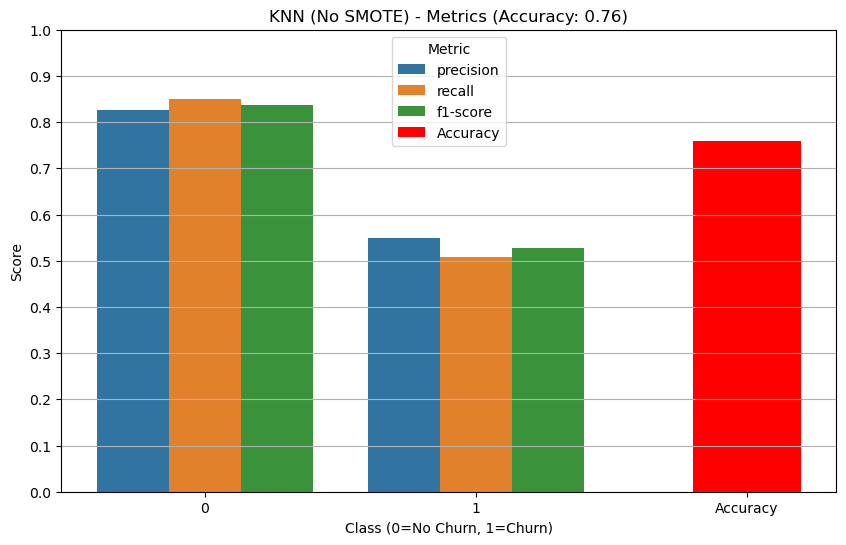

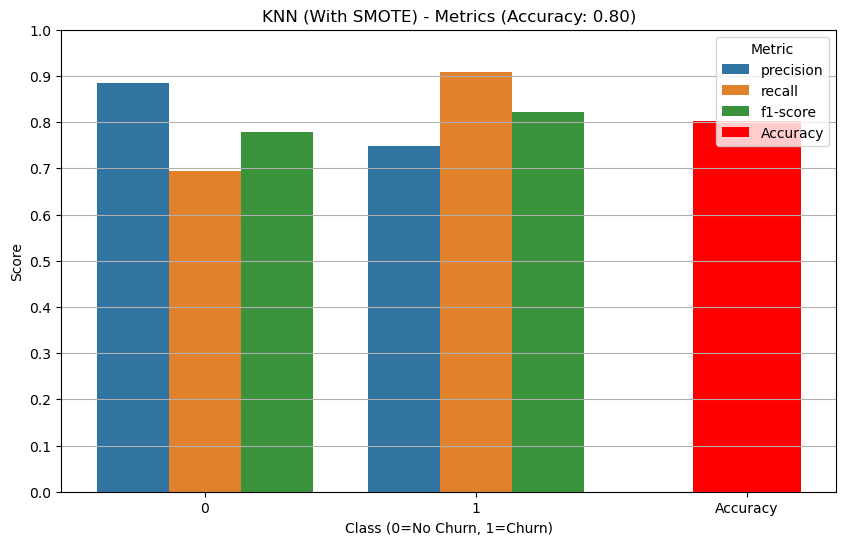

In [2]:
# ============================
# KNN model: Before and After SMOTE
# ============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE

# 1. Load dataset
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# 2. Data cleaning
df.replace([' ', 'NaN', 'N/A'], np.nan, inplace=True)
df.dropna(inplace=True)

# Replace 'No internet service' & 'No phone service' with 'No'
replace_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                'StreamingTV', 'StreamingMovies', 'MultipleLines']
for col in replace_cols:
    df[col] = df[col].replace({'No internet service': 'No', 'No phone service': 'No'})

# Drop irrelevant columns
df = df.drop(['customerID', 'gender', 'PhoneService'], axis=1)

# Convert SeniorCitizen to Yes/No
df['SeniorCitizen'] = df['SeniorCitizen'].replace({1: 'Yes', 0: 'No'})

# Encode categorical features
le = LabelEncoder()
df['Churn'] = le.fit_transform(df['Churn'])
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# 3. Split features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# 4. Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ================
# KNN WITHOUT SMOTE
# ================
print("\n=== KNN WITHOUT SMOTE ===")

# Split into train-test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y)

# Initialize and train KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict
y_pred = knn.predict(X_test)
y_prob = knn.predict_proba(X_test)[:,1]

# Evaluate
print("Classification Report (No SMOTE):")
print(classification_report(y_test, y_pred))
print("AUC Score (No SMOTE): {:.3f}".format(roc_auc_score(y_test, y_prob)))


# ================
# KNN WITH SMOTE
# ================
print("\n=== KNN WITH SMOTE ===")

# Apply SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_scaled, y)

# Split into train-test
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_smote, y_smote, test_size=0.2, stratify=y_smote)

# Initialize and train KNN
knn_smote = KNeighborsClassifier(n_neighbors=5)
knn_smote.fit(X_train_s, y_train_s)

# Predict
y_pred_s = knn_smote.predict(X_test_s)
y_prob_s = knn_smote.predict_proba(X_test_s)[:,1]

# Evaluate
print("Classification Report (SMOTE):")
print(classification_report(y_test_s, y_pred_s))
print("AUC Score (SMOTE): {:.3f}".format(roc_auc_score(y_test_s, y_prob_s)))




# ==== KNN NO SMOTE METRICS GRAPH ====

from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Classification report & accuracy
report_knn = classification_report(y_test, y_pred, output_dict=True)
acc_knn = accuracy_score(y_test, y_pred)

# Format report
df_knn = pd.DataFrame(report_knn).transpose()
metrics_knn = df_knn[['precision', 'recall', 'f1-score']].drop(['accuracy','macro avg','weighted avg'], errors='ignore')
metrics_knn = metrics_knn.reset_index().rename(columns={'index':'Class'})
metrics_knn_melted = pd.melt(metrics_knn, id_vars='Class', value_vars=['precision', 'recall', 'f1-score'],
                             var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(10,6))
sns.barplot(data=metrics_knn_melted, x='Class', y='Score', hue='Metric')

# Add red Accuracy bar
plt.bar('Accuracy', acc_knn, color='red', width=0.4, label='Accuracy')

plt.title(f'KNN (No SMOTE) - Metrics (Accuracy: {acc_knn:.2f})')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim(0,1)
plt.ylabel('Score')
plt.xlabel('Class (0=No Churn, 1=Churn)')

# Add legend for Accuracy
handles, labels = plt.gca().get_legend_handles_labels()
if 'Accuracy' not in labels:
    handles.append(plt.Rectangle((0,0),1,1, color='red'))
    labels.append('Accuracy')
plt.legend(handles=handles, labels=labels, title='Metric')

plt.grid(axis='y')
plt.show()

# ==== KNN WITH SMOTE METRICS GRAPH ====

# Classification report & accuracy
report_knn_s = classification_report(y_test_s, y_pred_s, output_dict=True)
acc_knn_s = accuracy_score(y_test_s, y_pred_s)

# Format report
df_knn_s = pd.DataFrame(report_knn_s).transpose()
metrics_knn_s = df_knn_s[['precision', 'recall', 'f1-score']].drop(['accuracy','macro avg','weighted avg'], errors='ignore')
metrics_knn_s = metrics_knn_s.reset_index().rename(columns={'index':'Class'})
metrics_knn_s_melted = pd.melt(metrics_knn_s, id_vars='Class', value_vars=['precision', 'recall', 'f1-score'],
                               var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(10,6))
sns.barplot(data=metrics_knn_s_melted, x='Class', y='Score', hue='Metric')

# Add red Accuracy bar
plt.bar('Accuracy', acc_knn_s, color='red', width=0.4, label='Accuracy')

plt.title(f'KNN (With SMOTE) - Metrics (Accuracy: {acc_knn_s:.2f})')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim(0,1)
plt.ylabel('Score')
plt.xlabel('Class (0=No Churn, 1=Churn)')

# Add legend for Accuracy
handles, labels = plt.gca().get_legend_handles_labels()
if 'Accuracy' not in labels:
    handles.append(plt.Rectangle((0,0),1,1, color='red'))
    labels.append('Accuracy')
plt.legend(handles=handles, labels=labels, title='Metric')

plt.grid(axis='y')
plt.show()


=== Random Forest ===
Accuracy: 0.8
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1979
           1       0.64      0.51      0.57       694

    accuracy                           0.80      2673
   macro avg       0.74      0.70      0.72      2673
weighted avg       0.79      0.80      0.79      2673



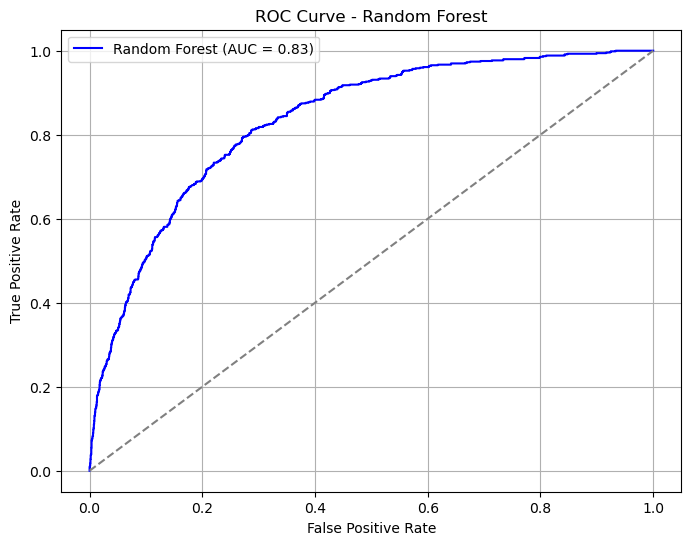

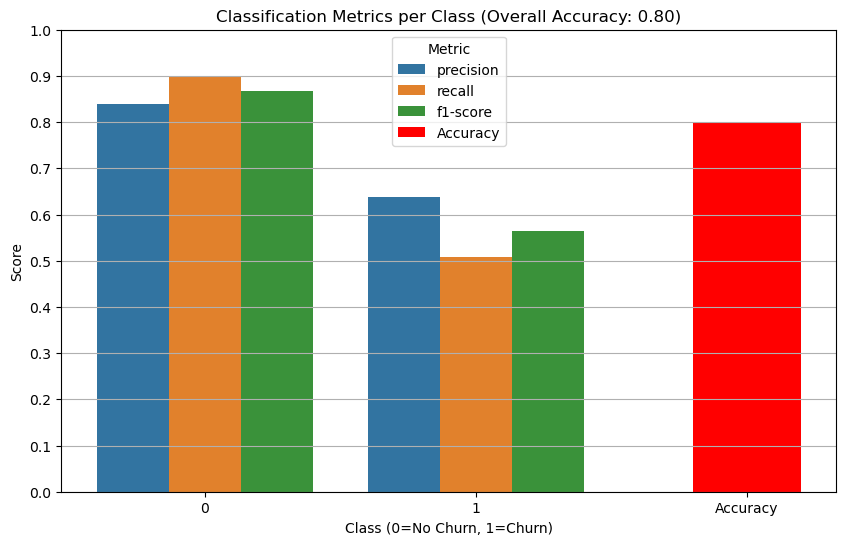

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score

# Load dataset
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Data cleaning
df.replace([' ', 'NaN', 'N/A'], np.nan, inplace=True)
df.dropna(inplace=True)

replace_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                'StreamingTV', 'StreamingMovies', 'MultipleLines']
for col in replace_cols:
    df[col] = df[col].replace({'No internet service': 'No', 'No phone service': 'No'})

df = df.drop(['customerID', 'gender', 'PhoneService'], axis=1)
df['SeniorCitizen'] = df['SeniorCitizen'].replace({1: 'Yes', 0: 'No'})

# Encode categorical features
le = LabelEncoder()
df['Churn'] = le.fit_transform(df['Churn'])
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# Split features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.38, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Random Forest with GridSearchCV
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)
rf_best = grid_rf.best_estimator_
y_pred_rf = rf_best.predict(X_test)

print("=== Random Forest ===")
##print("Best Params:", grid_rf.best_params_)
print("Accuracy:", round(accuracy_score(y_test, y_pred_rf), 2))

print(classification_report(y_test, y_pred_rf))

# ROC Curve
y_prob_rf = rf_best.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_rf)
auc_score = roc_auc_score(y_test, y_prob_rf)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'Random Forest (AUC = {auc_score:.2f})')
plt.plot([0,1], [0,1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.grid(True)
plt.show()

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import numpy as np

# 生成 classification report
report = classification_report(y_test, y_pred_rf, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# 提取 per class 的 precision, recall, f1-score
metrics_df = df_report[['precision', 'recall', 'f1-score']].drop(['accuracy','macro avg','weighted avg'], errors='ignore')
metrics_df = metrics_df.reset_index().rename(columns={'index':'Class'})

# 转为 long format 以便绘图
metrics_melted = pd.melt(metrics_df, id_vars='Class', value_vars=['precision', 'recall', 'f1-score'],
                         var_name='Metric', value_name='Score')

# 计算 accuracy
acc = accuracy_score(y_test, y_pred_rf)

# 绘图
plt.figure(figsize=(10,6))
sns.barplot(data=metrics_melted, x='Class', y='Score', hue='Metric')

# 添加红色 Accuracy bar（单独一根）
plt.bar('Accuracy', acc, color='red', width=0.4, label='Accuracy')

# 设置图表信息
plt.title(f'Classification Metrics per Class (Overall Accuracy: {acc:.2f})')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim(0,1)
plt.ylabel('Score')
plt.xlabel('Class (0=No Churn, 1=Churn)')

# 补上 Accuracy 图例
handles, labels = plt.gca().get_legend_handles_labels()
if 'Accuracy' not in labels:
    handles.append(plt.Rectangle((0,0),1,1, color='red'))
    labels.append('Accuracy')
plt.legend(handles=handles, labels=labels, title='Metric')


plt.grid(axis='y')
plt.show()



=== Logistic Regression ===
Accuracy: 0.8
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1979
           1       0.64      0.52      0.58       694

    accuracy                           0.80      2673
   macro avg       0.74      0.71      0.72      2673
weighted avg       0.79      0.80      0.79      2673



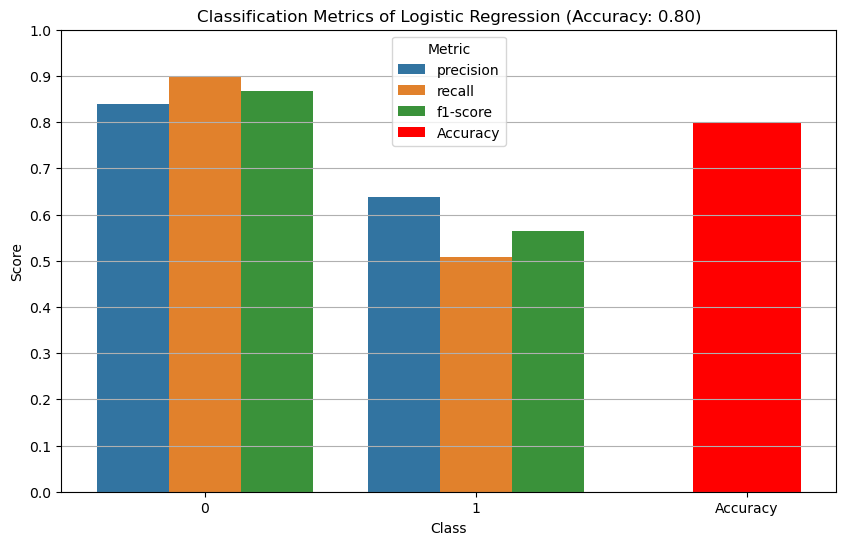

In [7]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Load dataset
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Data cleaning
df.replace([' ', 'NaN', 'N/A'], np.nan, inplace=True)
df.dropna(inplace=True)

replace_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                'StreamingTV', 'StreamingMovies', 'MultipleLines']
for col in replace_cols:
    df[col] = df[col].replace({'No internet service': 'No', 'No phone service': 'No'})

df = df.drop(['customerID', 'gender', 'PhoneService'], axis=1)
df['SeniorCitizen'] = df['SeniorCitizen'].replace({1: 'Yes', 0: 'No'})

# Encode categorical features
le = LabelEncoder()
df['Churn'] = le.fit_transform(df['Churn'])
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# Split features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.38, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Logistic Regression with GridSearchCV (no class_weight and no threshold adjustment)
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs', 'saga'],
    'penalty': ['l2'],
    'max_iter': [500, 1000]
}

grid_lr = GridSearchCV(LogisticRegression(), param_grid_lr, cv=5, scoring='accuracy', n_jobs=-1)
grid_lr.fit(X_train, y_train)
lr_best = grid_lr.best_estimator_
y_pred_lr = lr_best.predict(X_test)

print("=== Logistic Regression ===")

print("Accuracy:", round(accuracy_score(y_test, y_pred_lr), 2))
report_lr = classification_report(y_test, y_pred_lr, output_dict=True)

print(classification_report(y_test, y_pred_lr))


metrics_df = df_report[['precision', 'recall', 'f1-score']].drop(['accuracy','macro avg','weighted avg'], errors='ignore')
metrics_df = metrics_df.reset_index().rename(columns={'index':'Class'})

# 转为 long format
metrics_melted = pd.melt(metrics_df, id_vars='Class', value_vars=['precision', 'recall', 'f1-score'],
                         var_name='Metric', value_name='Score')

# 计算 accuracy
acc = accuracy_score(y_test, y_pred_lr)

# 设置图像
plt.figure(figsize=(10,6))
sns.barplot(data=metrics_melted, x='Class', y='Score', hue='Metric')

# 添加红色的 Accuracy 柱状图
plt.bar('Accuracy', acc, color='red', width=0.4, label='Accuracy')

# 标题与其他设置
plt.title(f'Classification Metrics of Logistic Regression (Accuracy: {acc:.2f})')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim(0,1)
plt.ylabel('Score')
plt.xlabel('Class')
plt.grid(axis='y')

# 添加 Accuracy 到图例
handles, labels = plt.gca().get_legend_handles_labels()
if 'Accuracy' not in labels:
    handles.append(plt.Rectangle((0,0),1,1, color='red'))
    labels.append('Accuracy')
plt.legend(handles=handles, labels=labels, title='Metric')

plt.show()




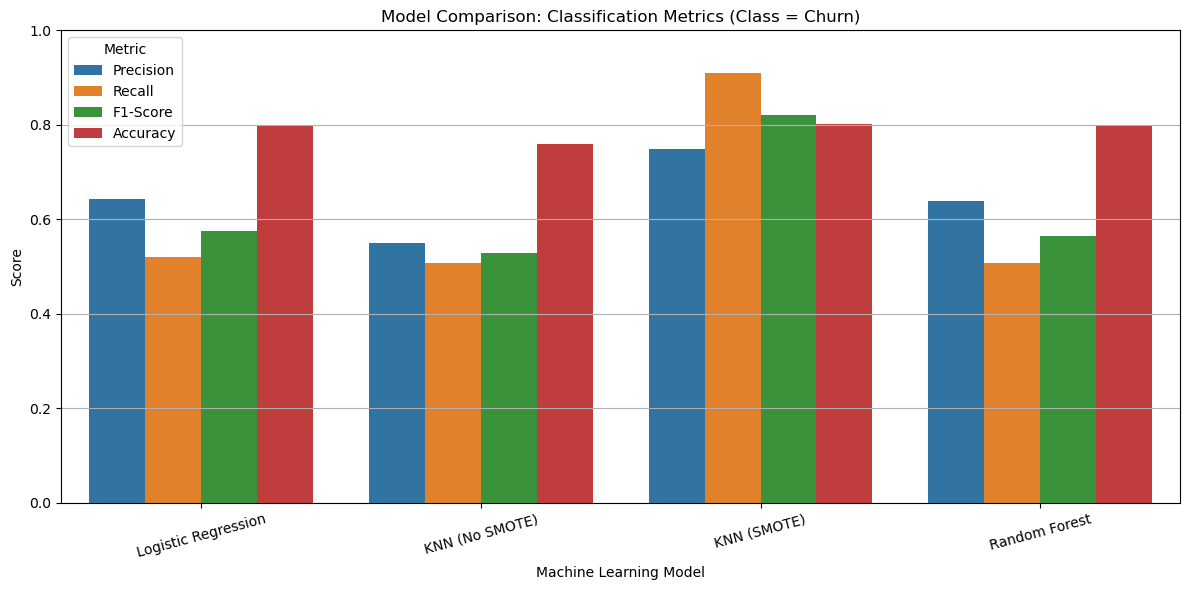

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 准备每个模型的指标
def extract_metrics(report_dict, model_name):
    metrics = report_dict['1']  # Class 1 = churn
    return {
        'Model': model_name,
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1-Score': metrics['f1-score'],
        'Accuracy': report_dict['accuracy']
    }

# 从每个模型提取 metrics
metrics_summary = [
    extract_metrics(report_lr, "Logistic Regression"),
    extract_metrics(report_knn, "KNN (No SMOTE)"),
    extract_metrics(report_knn_s, "KNN (SMOTE)"),
    extract_metrics(report, "Random Forest")
]

# 创建 DataFrame
df_compare = pd.DataFrame(metrics_summary)

# 转为长格式
df_melted = pd.melt(df_compare, id_vars='Model', var_name='Metric', value_name='Score')

# 绘图
plt.figure(figsize=(12,6))
sns.barplot(data=df_melted, x='Model', y='Score', hue='Metric')
plt.title('Model Comparison: Classification Metrics (Class = Churn)')
plt.ylim(0,1)
plt.ylabel('Score')
plt.xlabel('Machine Learning Model')
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()
